In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Load data from yahoo finance

The yf.download function from the yfinance library is used to retrieve the historical data for the S&P 500 index.

^GSPC is the ticker symbol for the S&P 500 index.

The start parameter specifies the start date for the data retrieval (January 1, 2010, in this case).

The end parameter specifies the end date for the data retrieval (April 10, 2020, in this case).

The retrieved data is stored in a DataFrame called df.

In [4]:
df = yf.download("^GSPC", start="2010-01-01", end="2020-04-10")     #^GSPC is the annotation for stock S&P500
df.reset_index(drop = True, inplace = True)
#Drop columns
df.drop(["Adj Close", "Volume"], axis = 1, inplace = True)


[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close
0,1116.560059,1133.869995,1116.560059,1132.989990
1,1132.660034,1136.630005,1129.660034,1136.520020
2,1135.709961,1139.189941,1133.949951,1137.140015
3,1136.270020,1142.459961,1131.319946,1141.689941
4,1140.520020,1145.390015,1136.219971,1144.979980
...,...,...,...,...
2580,2514.919922,2538.179932,2459.959961,2488.649902
2581,2578.280029,2676.850098,2574.570068,2663.679932
2582,2738.649902,2756.889893,2657.669922,2659.409912
2583,2685.000000,2760.750000,2663.300049,2749.979980


## Create input


In Keras, the input shape for an LSTM (Long Short-Term Memory) layer depends on the format of your data. 
The LSTM layer expects input in the form of a 3D tensor with shape (batch_size, timesteps, input_dim).

+Batch_size: The number of samples in each batch. This dimension is typically left unspecified or set to None in the input shape, allowing for variable batch sizes during training and inference.

+Timesteps: The number of time steps or sequences in your input data. For example, if you have a time series of length 100, and you want to consider 20 previous time steps as input for each sample, then timesteps would be 20.

+Input_dim: The number of features or dimensions in each time step of your input data. 

In [6]:
#Sequence Creation Function for Time Series Data
def create_sequences(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data.iloc[i:i+seq_length, :]) 
        y.append(data.iloc[i+seq_length, 3]) 
    return np.array(X), np.array(y)

seq_length = 20
num_features = 4
X,Y = create_sequences(df,seq_length)

In [7]:
print(X.shape)
print(Y.shape)

(2565, 20, 4)
(2565,)


## Data preparation


Since in this model, we use time series so we can not suffle data. We dive whole data into 2 part: train set and test set without suffle.

In [8]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = X[0:train_size,:], X[train_size:,:]
y_train, y_test = Y[0:train_size], Y[train_size:]

In [9]:
scalerX = MinMaxScaler(feature_range=(0,1))
scalerY = MinMaxScaler(feature_range = (0,1))
x_train = scalerX.fit_transform(x_train.reshape(-1,num_features * seq_length))
x_test = scalerX.transform(x_test.reshape(-1,num_features * seq_length))
y_train = scalerY.fit_transform(y_train.reshape(-1,1))
y_test = scalerY.transform(y_test.reshape(-1,1))
    

In [10]:
x_train = x_train.reshape(-1,seq_length,num_features)
x_test = x_test.reshape(-1,seq_length, num_features)

In [11]:
print(x_train.shape)
print(y_train.shape)

(2068, 20, 4)
(2068, 1)


## Visualization

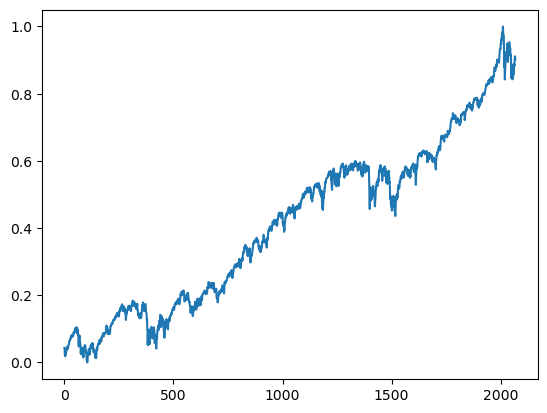

In [12]:
plt.plot(y_train)
plt.show()

## Grid search

In [93]:
def create_model(neurons, optimizer):
 # create model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(seq_length,4), activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

In [ ]:
optimizer = ['GDA','Nadam']
neurons = [100,500,1000,2000]
param_grid = dict(model__neurons=neurons, model__optimizer = optimizer)

model = KerasRegressor(model=create_model, epochs=10, batch_size=5, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

In [102]:
best_params = grid.best_params_
best_model = create_model(neurons=best_params['model__neurons'], optimizer=best_params['model__optimizer'])
best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred = best_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

Epoch 1/10
65/65 [==============================] - 16s 223ms/step - loss: 0.0065
Epoch 2/10
65/65 [==============================] - 14s 222ms/step - loss: 2.3028e-04
Epoch 3/10
65/65 [==============================] - 15s 228ms/step - loss: 2.2612e-04
Epoch 4/10
65/65 [==============================] - 15s 223ms/step - loss: 2.3561e-04
Epoch 5/10
65/65 [==============================] - 15s 228ms/step - loss: 2.3466e-04
Epoch 6/10
65/65 [==============================] - 15s 230ms/step - loss: 2.2816e-04
Epoch 7/10
65/65 [==============================] - 15s 228ms/step - loss: 2.0556e-04
Epoch 8/10
65/65 [==============================] - 17s 256ms/step - loss: 2.0155e-04
Epoch 9/10
65/65 [==============================] - 17s 258ms/step - loss: 2.0112e-04
Epoch 10/10
16/16 [==============================] - 2s 89ms/step


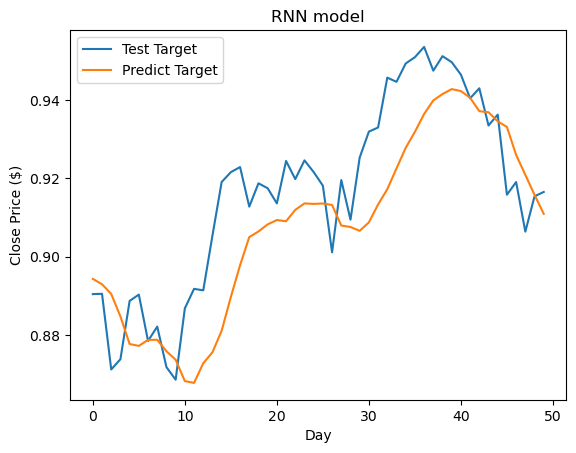

In [99]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test[0:], label = "Test Target")
plt.plot(y_pred[0:], label = "Predict Target")
plt.legend()
plt.show()

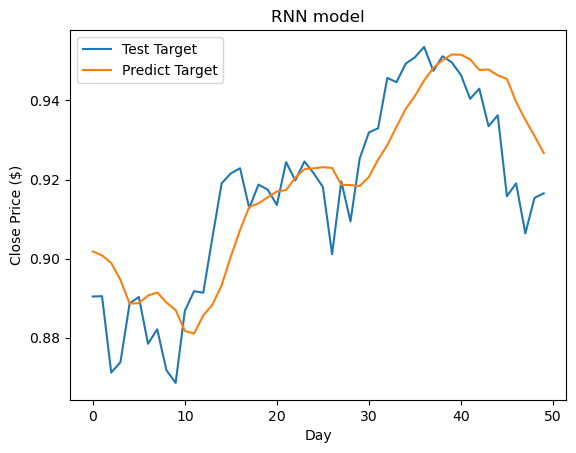

In [104]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test[0:], label = "Test Target")
plt.plot(y_pred[0:], label = "Predict Target")
plt.legend()
plt.show()

Actually in this case, when we run more complex model, we have more smooth model and the mean square error decrease but not significantly. All of these models convergence to an similar shape with a tiny difference about degree of smoothness. Running all of this grid search is time-consuming without a big improvement so we choose a not complex model to analyze and get insight from this family of models.

## Create model


In [13]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(seq_length, num_features), activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10
65/65 - 1s - loss: 0.0150 - 957ms/epoch - 15ms/step
Epoch 2/10
65/65 - 0s - loss: 2.2422e-04 - 351ms/epoch - 5ms/step
Epoch 3/10
65/65 - 0s - loss: 1.9973e-04 - 345ms/epoch - 5ms/step
Epoch 4/10
65/65 - 0s - loss: 1.9343e-04 - 347ms/epoch - 5ms/step
Epoch 5/10
65/65 - 0s - loss: 1.8754e-04 - 344ms/epoch - 5ms/step
Epoch 6/10
65/65 - 0s - loss: 1.8662e-04 - 339ms/epoch - 5ms/step
Epoch 7/10
65/65 - 0s - loss: 1.8106e-04 - 342ms/epoch - 5ms/step
Epoch 8/10
65/65 - 0s - loss: 1.8870e-04 - 337ms/epoch - 5ms/step
Epoch 9/10
65/65 - 0s - loss: 1.7190e-04 - 342ms/epoch - 5ms/step
Epoch 10/10
65/65 - 0s - loss: 1.6942e-04 - 342ms/epoch - 5ms/step


In [14]:
x_train.shape

(2068, 20, 4)

In [15]:

# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict.reshape(-1,1))
trainY = scalerY.inverse_transform(y_train.reshape(-1,1))
testPredict = scalerY.inverse_transform(testPredict.reshape(-1,1))
testY = scalerY.inverse_transform(y_test.reshape(-1,1))
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

16/16 [==============================] - 0s 2ms/step
[[0.9115756 ]
 [0.9113502 ]
 [0.9098219 ]
 [0.9065291 ]
 [0.90035254]
 [0.899826  ]
 [0.90107644]
 [0.90165263]
 [0.89856154]
 [0.8968486 ]
 [0.89174604]
 [0.8904607 ]
 [0.8947649 ]
 [0.8970979 ]
 [0.90151423]
 [0.90880305]
 [0.9157794 ]
 [0.922057  ]
 [0.9237434 ]
 [0.9258047 ]
 [0.9277356 ]
 [0.92833936]
 [0.9315055 ]
 [0.93383837]
 [0.9338303 ]
 [0.9342764 ]
 [0.934223  ]
 [0.93050265]
 [0.9300202 ]
 [0.9297176 ]
 [0.9314176 ]
 [0.9354871 ]
 [0.93902534]
 [0.9435018 ]
 [0.9483977 ]
 [0.95178753]
 [0.95611835]
 [0.95957667]
 [0.9619269 ]
 [0.9636012 ]
 [0.9638169 ]
 [0.9627904 ]
 [0.9602193 ]
 [0.9603355 ]
 [0.959058  ]
 [0.9579162 ]
 [0.9524876 ]
 [0.9477046 ]
 [0.94369984]
 [0.9385978 ]
 [0.9380077 ]
 [0.9355194 ]
 [0.93551654]
 [0.9359227 ]
 [0.9392777 ]
 [0.9462741 ]
 [0.95320666]
 [0.9564915 ]
 [0.960507  ]
 [0.96478134]
 [0.9678187 ]
 [0.97037274]
 [0.97426933]
 [0.97626776]
 [0.97745883]
 [0.97801787]
 [0.9812313 ]
 [0.98510

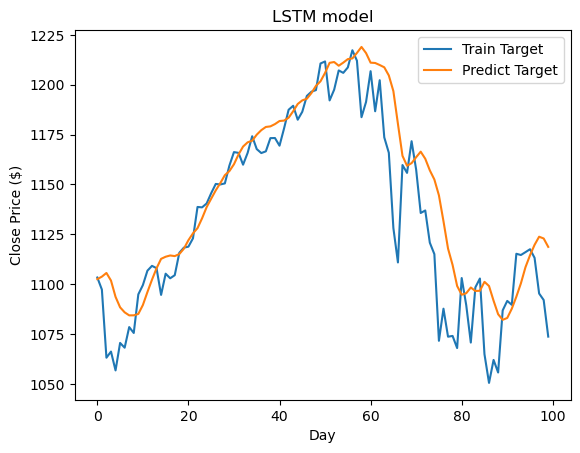

In [16]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(trainY[0:100], label = "Train Target")
plt.plot(trainPredict[0:100], label = "Predict Target")
plt.legend()
plt.show()

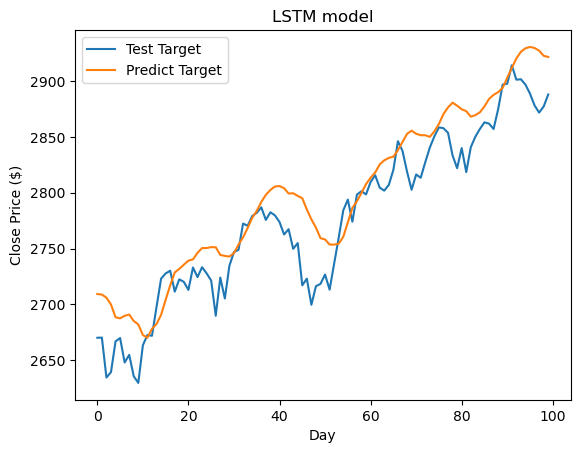

In [17]:
plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(testY[0:100], label = "Test Target")
plt.plot(testPredict[0:100], label = "Predict Target")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import r2_score
r2_test = r2_score(testY, testPredict)
r2_train = r2_score(trainY, trainPredict)
print("R-squared on train set:", r2_train)
print("R-squared on test set:", r2_test)




R-squared on train set: 0.9969656480442792
R-squared on test set: 0.8762134726855786


## Test for other stock without training


In [19]:
df_test = yf.download("IBM", start="2018-01-01", end="2020-04-10")
df_test.reset_index(drop = True, inplace = True)
#Drop columns
df_test.drop(["Adj Close", "Volume"], axis = 1, inplace = True)

[*********************100%***********************]  1 of 1 completed


In [20]:
df_test

,Open,High,Low,Close
0,147.705551,148.001907,146.787766,147.466537
1,150.420654,152.782028,149.455063,151.520081
2,152.629059,155.181641,152.361374,154.588913
3,155.296371,155.736145,154.015289,155.344162
4,155.506699,156.701721,154.588913,156.281067
...,...,...,...,...
567,104.130020,105.229446,100.305923,101.663483
568,105.497131,110.544930,105.286804,109.770554
569,113.575523,114.311661,109.818359,109.885277
570,111.195030,114.684509,110.009560,114.043976


In [21]:
otherX,otherY = create_sequences(df,seq_length)
print(otherX.shape)
print(otherY.shape)

(2565, 20, 4)
(2565,)


In [22]:
otherx_test = scalerX.transform(otherX.reshape(-1,num_features * seq_length))
othery_test = scalerY.transform(otherY.reshape(-1,1))

In [23]:
otherx_test = otherx_test.reshape(-1,seq_length, num_features)
print(otherx_test.shape)

(2565, 20, 4)


In [24]:
otherPredict = model.predict(otherx_test)

81/81 [==============================] - 0s 2ms/step


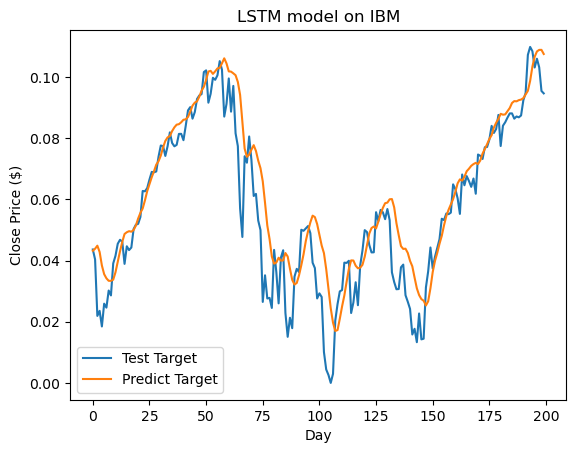

In [25]:
plt.title("LSTM model on IBM")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(othery_test[0:200], label = "Test Target")
plt.plot(otherPredict[0:200], label = "Predict Target")
plt.legend()
plt.show()

In [26]:
other_r2_test = r2_score(othery_test, otherPredict)
print(other_r2_test)

0.9958550409107935


As we can see, without training phase, our model can predict other stock price of IBM which fluatuate differently as well as S&P500

## Using RNN model

In [27]:

# create and fit the LSTM network
RNNmodel = Sequential()
RNNmodel.add(LSTM(50, input_shape=(seq_length, num_features), activation = 'relu'))
RNNmodel.add(Dense(1))
RNNmodel.compile(loss='mean_squared_error', optimizer='adam')
RNNmodel.fit(x_train, y_train, epochs= 10, batch_size=32, verbose=2)

Epoch 1/10
65/65 - 1s - loss: 0.0471 - 727ms/epoch - 11ms/step
Epoch 2/10
65/65 - 0s - loss: 3.2500e-04 - 184ms/epoch - 3ms/step
Epoch 3/10
65/65 - 0s - loss: 2.2736e-04 - 184ms/epoch - 3ms/step
Epoch 4/10
65/65 - 0s - loss: 2.0146e-04 - 182ms/epoch - 3ms/step
Epoch 5/10
65/65 - 0s - loss: 1.9470e-04 - 184ms/epoch - 3ms/step
Epoch 6/10
65/65 - 0s - loss: 1.8829e-04 - 178ms/epoch - 3ms/step
Epoch 7/10
65/65 - 0s - loss: 1.7946e-04 - 187ms/epoch - 3ms/step
Epoch 8/10
65/65 - 0s - loss: 1.8429e-04 - 184ms/epoch - 3ms/step
Epoch 9/10
65/65 - 0s - loss: 1.9553e-04 - 184ms/epoch - 3ms/step
Epoch 10/10
65/65 - 0s - loss: 1.6996e-04 - 183ms/epoch - 3ms/step


In [28]:

# make predictions
RNNtrainPredict = model.predict(x_train)
RNNtestPredict = model.predict(x_test)
print(testPredict)
# invert predictions
RNNtrainPredict = scalerY.inverse_transform(RNNtrainPredict.reshape(-1,1))
RNNtrainY = scalerY.inverse_transform(y_train.reshape(-1,1))
RNNtestPredict = scalerY.inverse_transform(RNNtestPredict.reshape(-1,1))
RNNtestY = scalerY.inverse_transform(y_test.reshape(-1,1))
# calculate root mean squared error
RNNtrainScore = np.sqrt(mean_squared_error(RNNtrainY, RNNtrainPredict))
print('Train Score: %.2f RMSE' % (RNNtrainScore))
RNNtestScore = np.sqrt(mean_squared_error(RNNtestY, RNNtestPredict))
print('Test Score: %.2f RMSE' % (RNNtestScore))

16/16 [==============================] - 0s 2ms/step
[[2709.2595]
 [2708.8423]
 [2706.0146]
 [2699.9219]
 [2688.4934]
 [2687.5193]
 [2689.8328]
 [2690.899 ]
 [2685.1797]
 [2682.0103]
 [2672.5688]
 [2670.1907]
 [2678.1545]
 [2682.4714]
 [2690.643 ]
 [2704.1294]
 [2717.0376]
 [2728.653 ]
 [2731.7734]
 [2735.5874]
 [2739.1602]
 [2740.277 ]
 [2746.1355]
 [2750.452 ]
 [2750.437 ]
 [2751.2625]
 [2751.1636]
 [2744.2798]
 [2743.3872]
 [2742.8274]
 [2745.9727]
 [2753.5027]
 [2760.0493]
 [2768.332 ]
 [2777.3909]
 [2783.663 ]
 [2791.6763]
 [2798.0752]
 [2802.4238]
 [2805.5217]
 [2805.921 ]
 [2804.0217]
 [2799.2644]
 [2799.4792]
 [2797.1155]
 [2795.003 ]
 [2784.9583]
 [2776.1086]
 [2768.6985]
 [2759.2583]
 [2758.1663]
 [2753.5623]
 [2753.5571]
 [2754.3086]
 [2760.5164]
 [2773.4617]
 [2786.2888]
 [2792.3667]
 [2799.7966]
 [2807.7056]
 [2813.3254]
 [2818.0513]
 [2825.261 ]
 [2828.9587]
 [2831.1624]
 [2832.1968]
 [2838.1426]
 [2845.309 ]
 [2852.612 ]
 [2855.5225]
 [2852.706 ]
 [2851.428 ]
 [2851.4004

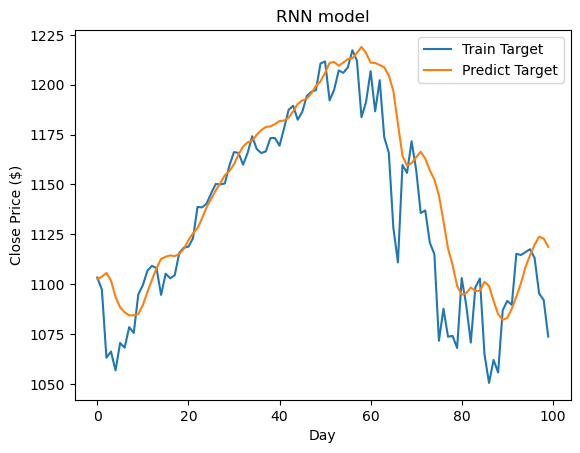

In [29]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(RNNtrainY[0:100], label = "Train Target")
plt.plot(RNNtrainPredict[0:100], label = "Predict Target")
plt.legend()
plt.show()

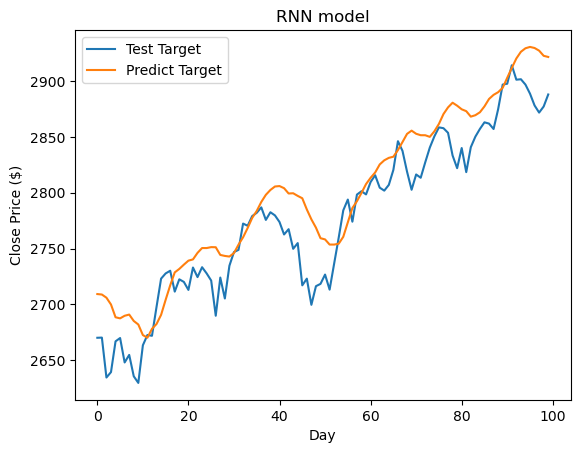

In [30]:
plt.title("RNN model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(RNNtestY[0:100], label = "Test Target")
plt.plot(RNNtestPredict[0:100], label = "Predict Target")
plt.legend()
plt.show()


## Test with random data

###### For simplictit, we create an new model with feature of each timestep is close price of previous day

In [31]:
df = yf.download("^GSPC", start="2010-01-01", end="2020-04-10")
df = df["Close"]

df = df.reset_index("Date")



[*********************100%***********************]  1 of 1 completed


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df.drop("Date", axis = 1, inplace = True)
scaledData = scaler.fit_transform(df)



In [33]:
def create_sequences(data, seq_length):
    print(data)
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
scaledX, scaledY = create_sequences(scaledData, 20)

[[0.04671323]
 [0.04820674]
 [0.04846905]
 ...
 [0.69252443]
 [0.73084362]
 [0.74769951]]


In [34]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
x_train, x_test = scaledX[0:train_size,:], scaledX[train_size:,:]
y_train, y_test = scaledY[0:train_size], scaledY[train_size:]


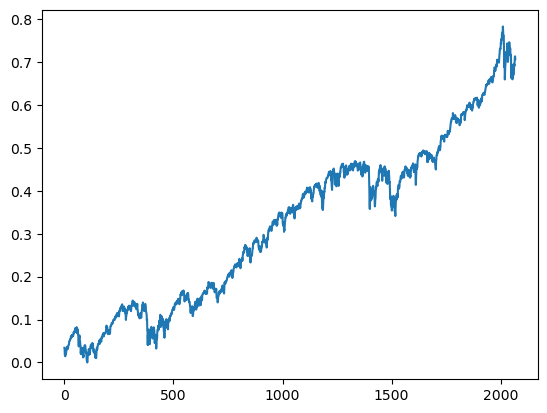

In [35]:
plt.plot(y_train)
plt.show()

In [36]:
seq_length = 20
x_train = np.reshape(x_train,(x_train.shape[0],seq_length,1))
x_test = np.reshape(x_test,(x_test.shape[0],seq_length,1))
print(len(x_test))

497


In [37]:
model = Sequential()
model.add(LSTM(100, input_shape=(seq_length,1), activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
2068/2068 - 4s - loss: 9.4374e-04 - 4s/epoch - 2ms/step
Epoch 2/10
2068/2068 - 4s - loss: 2.3445e-04 - 4s/epoch - 2ms/step
Epoch 3/10
2068/2068 - 3s - loss: 1.6445e-04 - 3s/epoch - 2ms/step
Epoch 4/10
2068/2068 - 3s - loss: 1.3855e-04 - 3s/epoch - 2ms/step
Epoch 5/10
2068/2068 - 6s - loss: 1.1537e-04 - 6s/epoch - 3ms/step
Epoch 6/10
2068/2068 - 9s - loss: 9.6275e-05 - 9s/epoch - 4ms/step
Epoch 7/10
2068/2068 - 9s - loss: 9.3533e-05 - 9s/epoch - 4ms/step
Epoch 8/10
2068/2068 - 7s - loss: 8.5158e-05 - 7s/epoch - 3ms/step
Epoch 9/10
2068/2068 - 8s - loss: 9.0920e-05 - 8s/epoch - 4ms/step
Epoch 10/10
2068/2068 - 11s - loss: 9.2954e-05 - 11s/epoch - 5ms/step


In [38]:

# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
print(testPredict)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

16/16 [==============================] - 0s 9ms/step
[[0.7050018 ]
 [0.69468945]
 [0.69416064]
 [0.6803138 ]
 [0.6811779 ]
 [0.693294  ]
 [0.69588   ]
 [0.68658257]
 [0.68807596]
 [0.6808919 ]
 [0.67780775]
 [0.6915646 ]
 [0.69696414]
 [0.6964784 ]
 [0.7064548 ]
 [0.71763456]
 [0.7199774 ]
 [0.72037715]
 [0.712429  ]
 [0.7161731 ]
 [0.7160453 ]
 [0.71304387]
 [0.7210099 ]
 [0.7184018 ]
 [0.7214101 ]
 [0.719463  ]
 [0.71651024]
 [0.70344603]
 [0.7164628 ]
 [0.7107844 ]
 [0.72176945]
 [0.7279583 ]
 [0.7286925 ]
 [0.737938  ]
 [0.73773175]
 [0.74071914]
 [0.7420805 ]
 [0.7440242 ]
 [0.7394417 ]
 [0.7418027 ]
 [0.74109954]
 [0.7385532 ]
 [0.7337823 ]
 [0.7355264 ]
 [0.7287618 ]
 [0.73029774]
 [0.71525383]
 [0.71643513]
 [0.7077951 ]
 [0.713999  ]
 [0.71590453]
 [0.7192369 ]
 [0.7137798 ]
 [0.72261876]
 [0.73318416]
 [0.7436792 ]
 [0.7477916 ]
 [0.7390946 ]
 [0.7480133 ]
 [0.75043833]
 [0.74905163]
 [0.75334316]
 [0.7562657 ]
 [0.75165427]
 [0.7499973 ]
 [0.7522699 ]
 [0.75821894]
 [0.76929

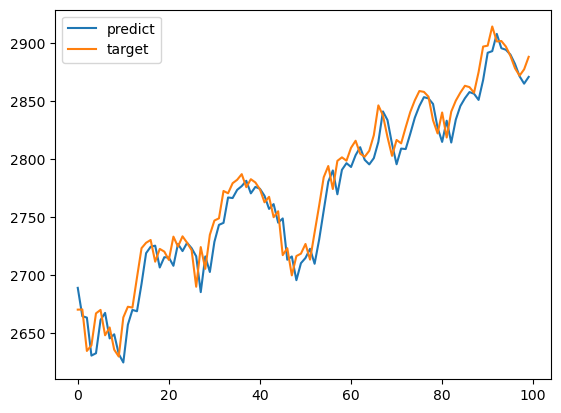

In [39]:
plt.plot(testPredict[:100], label = "predict")
plt.plot(testY[:100], label = "target")
plt.legend()

From here we can also see that compare to four-feature model, there is not many difference

#### Create random data


In [40]:
np.random.seed(100)
data_test = np.random.random((200,1))
data_test

array([[0.54340494],
       [0.27836939],
       [0.42451759],
       [0.84477613],
       [0.00471886],
       [0.12156912],
       [0.67074908],
       [0.82585276],
       [0.13670659],
       [0.57509333],
       [0.89132195],
       [0.20920212],
       [0.18532822],
       [0.10837689],
       [0.21969749],
       [0.97862378],
       [0.81168315],
       [0.17194101],
       [0.81622475],
       [0.27407375],
       [0.43170418],
       [0.94002982],
       [0.81764938],
       [0.33611195],
       [0.17541045],
       [0.37283205],
       [0.00568851],
       [0.25242635],
       [0.79566251],
       [0.01525497],
       [0.59884338],
       [0.60380454],
       [0.10514769],
       [0.38194344],
       [0.03647606],
       [0.89041156],
       [0.98092086],
       [0.05994199],
       [0.89054594],
       [0.5769015 ],
       [0.74247969],
       [0.63018394],
       [0.58184219],
       [0.02043913],
       [0.21002658],
       [0.54468488],
       [0.76911517],
       [0.250

In [41]:
df_test = pd.DataFrame(data_test)

In [42]:
def create_sequences(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data.iloc[i:i+seq_length, :]) 
        y.append(data.iloc[i+seq_length, 0]) 
    return np.array(X), np.array(y)
X_test, Y_test = create_sequences(df_test, 20)
X_test.shape

(180, 20, 1)

In [43]:
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 8ms/step


In [44]:
testPredict = scaler.inverse_transform(y_pred)
testY = scaler.inverse_transform(Y_test.reshape(-1,1))

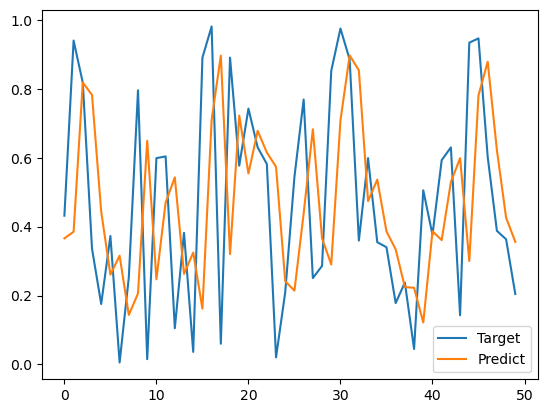

In [45]:
plt.plot(Y_test[0:50], label = 'Target')
plt.plot(y_pred[0:50], label = 'Predict')
plt.legend()

###### Shift 1 day 

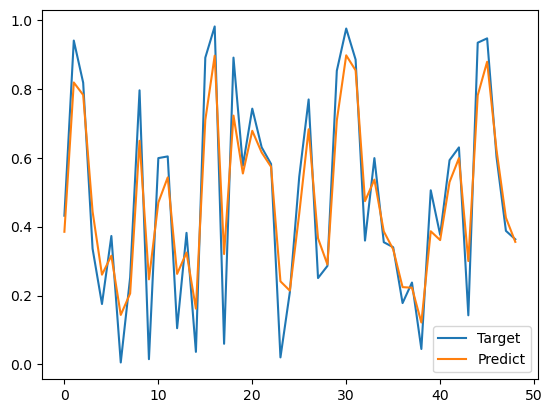

In [46]:
plt.plot(Y_test[0:49], label = 'Target')
plt.plot(y_pred[1:50], label = 'Predict')
plt.legend()